<a href="https://colab.research.google.com/github/lasseufpa/ml4comm/blob/main/qam_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inteligência Artificial e Aprendizado de Máquina Aplicados a Redes 5G e 6G**.
*Aldebaro Klautau* (UFPA). Minicurso 5 do SBrT - 25 de setembro de 2022.

# Detection of QAM over AWGN using machine learning

## Goal:
To get results as close as possible of the optimum provided by the theoretical equation for a given signal-to-noise ratio (SNR). You can modify any value in this notebook, but keep the modulation order as M=16 symbols (or classes, in the context of AI/ML), such that we have 4 bits per symbol.

In [182]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    import sys
    import os
    try:
      !git clone https://github.com/aldebaro/ai6g.git
    except:
      print("ai6g is already in the contents")
    !pip install -r /content/ai6g/requirements.txt  &>/dev/null
    sys.path.append(os.path.abspath('/content/ai6g'))

In [183]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from commpy.channels import SISOFlatChannel

from files_01_detection.qam_crazy import crazy_channel_propagate
from files_01_detection.qam_awgn import generate_symbols
from files_01_detection.qam_analyzer import plot_decision_boundary, theoretical_ser, ser, plot_confusion_matrix
 
%matplotlib inline

### Variables

In [184]:
channel_type = 'awgn' # 'awgn' or 'crazy'
M            = 16      # QAM modulation
total_num_symbols  = 200    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [185]:
#plot theoretical symbol error probability (SER) for this SNR
Pe = theoretical_ser(M, SNR_dB)
print("Theoretical symbol error probability (SER) =", 100.0*Pe, "% for SNR =", SNR_dB,"dB")

Theoretical symbol error probability (SER) = 1.7781842241805894 % for SNR = 15 dB


### Generate QAM symbols and transmit them over the channel

In [186]:
# Generate the QAM symbols
symbs, indices = generate_symbols(total_num_symbols, M)

In [187]:
if channel_type == 'awgn':
    channel = SISOFlatChannel(None, (1 + 0j, 0j))
    channel.set_SNR_dB(SNR_dB, float(code_rate), Es)
    channel_output = channel.propagate(symbs)
elif channel_type == 'crazy':
    channel_output = crazy_channel_propagate(symbs, SNR_dB) 
else:
    raise ValueError(f'Channel type {channel_type} not found')

In [188]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

In [189]:
def plot_symbols():
    custom_cmap = cm.get_cmap('tab20')
    num_classes = M
    colors = custom_cmap.colors[:num_classes]
    levels = np.arange(num_classes + 2) - 0.5

    for ii in range(num_classes):
        selected_indices = np.argwhere(y_train==ii)
        selected_indices = selected_indices.reshape((-1))
        plt.plot(X_train[selected_indices, 0], X_train[selected_indices, 1], 'o', color=colors[ii], label=f'{ii}')
        
    plt.plot(np.real(symbs), np.imag(symbs), 'rx')
    plt.legend(title='Classes', bbox_to_anchor=(1, 1), loc='upper left', ncol=2, handleheight=2, labelspacing=0.05, frameon=False)
    plt.ylabel('Quadrature')
    plt.xlabel('In-phase')

    plt.show()  

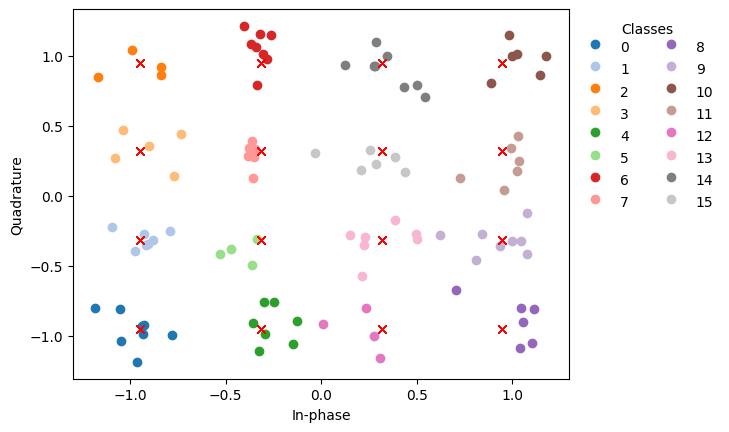

In [190]:
plot_symbols()

## Classifiers

In [191]:
#choose any classifier and its hyperparameters
#1) Gaussian Naive Bayes
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
classifier = GaussianNB(priors=None, var_smoothing=1e-09)

#2) Linear support vector machine (SVM), which corresponds to a maximum margin perceptron
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
# classifier = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, 
#                        multi_class='ovr', fit_intercept=True, intercept_scaling=1, 
#                        class_weight=None, verbose=0, random_state=None, max_iter=1000)
#3) Decision tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# classifier = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, min_samples_split=2, 
#                                     min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
#                                     random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                                     class_weight=None, ccp_alpha=0.0)
#4) Random forest
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# classifier = RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=100, 
#                                     min_samples_split=2, min_samples_leaf=1, 
#                                     min_weight_fraction_leaf=0.0, max_features='sqrt', 
#                                     max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                                     bootstrap=True, oob_score=False, n_jobs=None, 
#                                     random_state=None, verbose=0, warm_start=False, 
#                                     class_weight=None, ccp_alpha=0.0, max_samples=None)
#5) Adaboost
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
# classifier = AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, 
#                                 algorithm='SAMME.R', random_state=None)
#6) SVC
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# classifier = SVC(C=1.0, kernel='rbf', degree=3, gamma=1, coef0=0.0, shrinking=True, 
#                  probability=False, tol=0.001, cache_size=200, class_weight=None, 
#                  verbose=False, max_iter=-1, decision_function_shape='ovr', 
#                  break_ties=False, random_state=None)
#7) MLP
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# classifier = MLPClassifier(alpha=0.1, max_iter=500, hidden_layer_sizes=(100,), 
#                            activation='relu', solver='adam', batch_size='auto', 
#                            learning_rate='constant', learning_rate_init=0.001, power_t=0.5,  
#                            shuffle=True, random_state=None, tol=0.0001, verbose=False, 
#                            warm_start=False, momentum=0.9, nesterovs_momentum=True, 
#                            early_stopping=False, validation_fraction=0.1, beta_1=0.9, 
#                            beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
#8) KNN
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# classifier = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto', 
#                                   leaf_size=30, p=2, metric='minkowski', 
#                                   metric_params=None, n_jobs=None)

## Train the classifier

In [192]:
classifier.fit(X_train, y_train) #train the classifier based on the training set

GaussianNB()

### Plot decision regions for training set and confusion matrix for test set

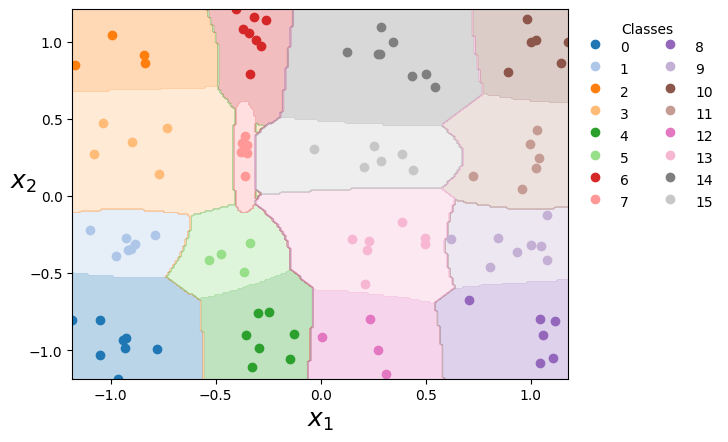

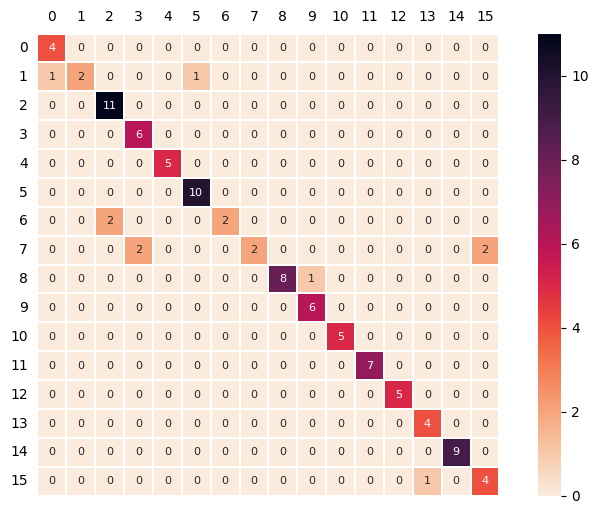

In [193]:
plot_decision_boundary(classifier, X_train, y_train, legend=True)
plot_confusion_matrix(classifier, X_test, y_test, M)

Calculate the misclassification error (that corresponds to the SER in this QAM detection case)

In [194]:
y_predicted = classifier.predict(X_test) #use the predict method
empirical_SER = np.sum(y_test != y_predicted)/len(y_test)
print(f'Empirical SER obtained with machine learning:\t {empirical_SER:.2%}')
print(f'Theoretical SER for AWGN channel:\t {Pe:.2%}')

Empirical SER obtained with machine learning:	 10.00%
Theoretical SER for AWGN channel:	 1.78%


In [195]:
scores = cross_val_score(classifier, X_train, y_train, scoring="accuracy", cv=3)

In [196]:
print("Scores: ", scores)
print("Score mean : ", scores.mean())
print("Score standard deviation: ", scores.std())

Scores:  [1.         0.84848485 0.90909091]
Score mean :  0.9191919191919192
Score standard deviation:  0.06226680811079774
